# Homework 5: Machine Reading

## 1. Random QA

1) What is the probability $p_{k,n}$ that our random QA system will output an answer with $k$ tokens when given a context paragraph with $n$ token as input?

$$p_{k,n} = \frac{2(n - k + 1)}{n(n+1)}$$

2) For a fixed $n$ of $100$, produce a plot of $p_{k,n}$ and $\hat{p}_{k,n}$  vs $k$. Design a monte-carlo experiment to estimate the values for $\hat{p}_{k,n}$.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def p_k_n(k, n):
    #implement answer from part 1 here
    p_k_n = 2*(n-k+1)/(n*(n+1))
    return p_k_n

In [0]:
def monte_carlo_p_k_n(k, n, T = int(1e5)):
    #T is the number of times you run experiment
    tuples = np.random.randint(1, n+1, size = (2,T)) # draw T tuples at the same time
    valid_tuples_mask = tuples[1] >= tuples[0]
    valid_tuples = tuples[:, valid_tuples_mask]
    
    k_list = valid_tuples[1]-valid_tuples[0]

    p_k_n_hat = sum([i==k for i in k_list])/len(k_list)
    return p_k_n_hat

In [0]:
k_array = np.arange(1, 100, 5)
p_k_n_hat = [monte_carlo_p_k_n(k, n=100, T = int(1e5)) for k in k_array]
p_k_n = [p_k_n(k, n=100) for k in k_array]

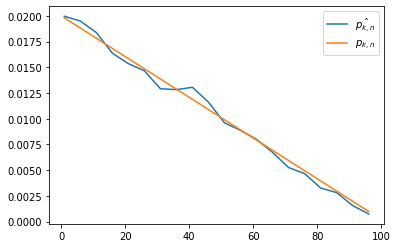

In [0]:
plt.plot(k_array, p_k_n_hat, label = r'$\hat{p_{k,n}}$')
plt.plot(k_array, p_k_n, label = r'$p_{k, n}$')
plt.legend()

3) Calculate the expected length of the answer given by your random QA system. i,e write an expression for $L_n = E[K]$ (It's fine to leave it as a summation).

$$ L_n = \sum_{k=1}^{n} \frac{2*k*(n-k+1)}{(1+n)*n}$$

4) Plot $\hat{L_n}$ estimated through monte-carlo simulations and $L_n$ for $n = 5, 10, 25, 50, 100, 250$ and $500$.

In [0]:
def L_n(n):
    #implement answer from above
    # l_n = (n-1)/3
    exp = 0
    for k in range(1, n+1):
        exp+=k*2*(n-k+1)/((1+n)*n)
    l_n = exp
    return l_n

def monte_carlo_L_n(n, T = int(1e5)):
    #T is the number of times you run experiment
    tuples = np.random.randint(1, n+1, size = (2,T)) # draw T tuples at the same time
    valid_tuples_mask = tuples[1] >= tuples[0]
    valid_tuples = tuples[:, valid_tuples_mask]

    k_list = valid_tuples[1]-valid_tuples[0]

    assert (k_list<0).sum()==0
    
    l_n = k_list.mean()
    return l_n

In [0]:
n_array = [5, 10, 25, 50, 100, 250, 500]
l_n_hat = [monte_carlo_L_n(n, T = int(1e5)) for n in n_array]
l_n = [L_n( n) for n in n_array]

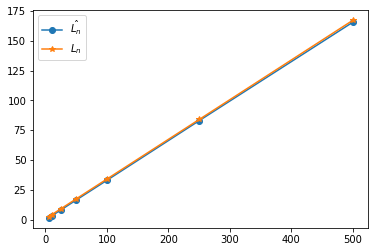

In [0]:
plt.plot(n_array, l_n_hat, '-o', label = r'$\hat{L_n}$')
plt.plot(n_array, l_n,  '-*', label = r'$L_n$')
plt.legend()

5) Calculate the probability, $p_n$ that Random QA system outputs the correct answer to your question. 

$$p_n = \frac{2}{n(n+1)}$$

6)  In SQuAD 2.0 data set, the answer for your question can either lie within the context paragraph or there could be no answer within the given paragraph. Let $\alpha$ represent the fraction of questions for which the answer \textbf{does not} lie within the paragraph.

##### load squad and set up

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pytorch-lightning
!pip install ujson

     |████████████████████████████████| 194kB 2.7MB/s 
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68034 sha256=8591ecccef837d6fe175e8e1dfe2897ef9b56ffcf1672885df2b731ac66f86fa
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
Successfully built ujson


In [0]:
import os
os.chdir("drive/My Drive/squad")

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from squad.util import collate_fn, SQuAD
from collections import OrderedDict
from json import dumps
from ujson import load as json_load
import pytorch_lightning as pl

from squad import layers, util
import os

DIR = os.getcwd()

In [0]:
seed = 224
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [0]:
## load dataset 
train_path = os.path.join(DIR, 'data/train.npz')
train_loader = data.DataLoader(SQuAD(train_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)


In [0]:
dev_path = os.path.join(DIR, 'data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)

In [0]:
test_path = os.path.join(DIR, 'data/test.npz')
test_loader = data.DataLoader(SQuAD(test_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)

##### -------end of set up --------

In [0]:
def estimate_alpha(list_of_answers):
    alpha = sum([1 if (i[0] == 0 and i[1]==0) else 0 for i in list_of_answers])/len(list_of_answers)
    return alpha

In [0]:
## load dataset and call function to find alpha
list_of_answers = [(train_loader.dataset[i][4], train_loader.dataset[i][5]) for i in range(len(train_loader.dataset))]
alpha = estimate_alpha(list_of_answers)
print('alpha, no answer probability for train set: ', alpha)

alpha, no answer probability for train set:  0.3336386447252967


In [0]:
## implement random QA model
## load dataset 
## find F1 and EM on Dev Set

In [0]:
## implement random QA model for dev set
predicted = []
ground_truth = []
for i in range(len(dev_loader.dataset)):
    batch = dev_loader.dataset[i]
    cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids = batch 
    # masks
    c_mask = torch.zeros_like(cw_idxs) != cw_idxs
    # get sequence length of context
    c_len = c_mask.sum(-1)

    # generate answers within context with probability alpha
    a = np.random.choice(2, 1, p=[alpha, 1-alpha]) # if a = 0, then actually randomly choose two indices, start (i) and end (j) tokens with constrain: 0<=i<=j<=len(seq)
    if a != 0:
        tuples = tuple((2,1))
        while tuples[0]>tuples[1]:
            tuples = np.random.randint(1, c_len+1, size = (2,1))
            i = tuples[0] # start token
            j = tuples[1] # end token
    else:
        i = j = 0
    predicted.append([i,j])
    ground_truth.append([int(y1), int(y2)])

In [0]:
## compute f1 and em scores
from collections import Counter
f1_lst = []
em_lst = []

def compute_f1_em(pred, gold):
    pred_toks = list(np.arange(pred[0], pred[1]+1))
    gold_toks = list(np.arange(gold[0], gold[1]+1))
    em = int(pred_toks == gold_toks)
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks)==0:
        return int(gold_toks == pred_toks), em
    if num_same == 0:
        return 0, 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, em

In [0]:
for pred, gold in zip(predicted, ground_truth):
    f1, em = compute_f1_em(pred, gold)
    f1_lst.append(f1)
    em_lst.append(em)

np.mean(f1_lst), np.mean(em_lst)

(0.1970511537107826, 0.18484288354898337)

##### F1 Score on Dev Set: 0.197
##### EM on Dev Set: 0.184

## 2. RNN Based Model

### 2.1.1 Diagram of Baseline

In [0]:
from google.colab import files
from IPython.display import Image

In [117]:
uploaded = files.upload()

Saving dig1.JPG to dig1.JPG


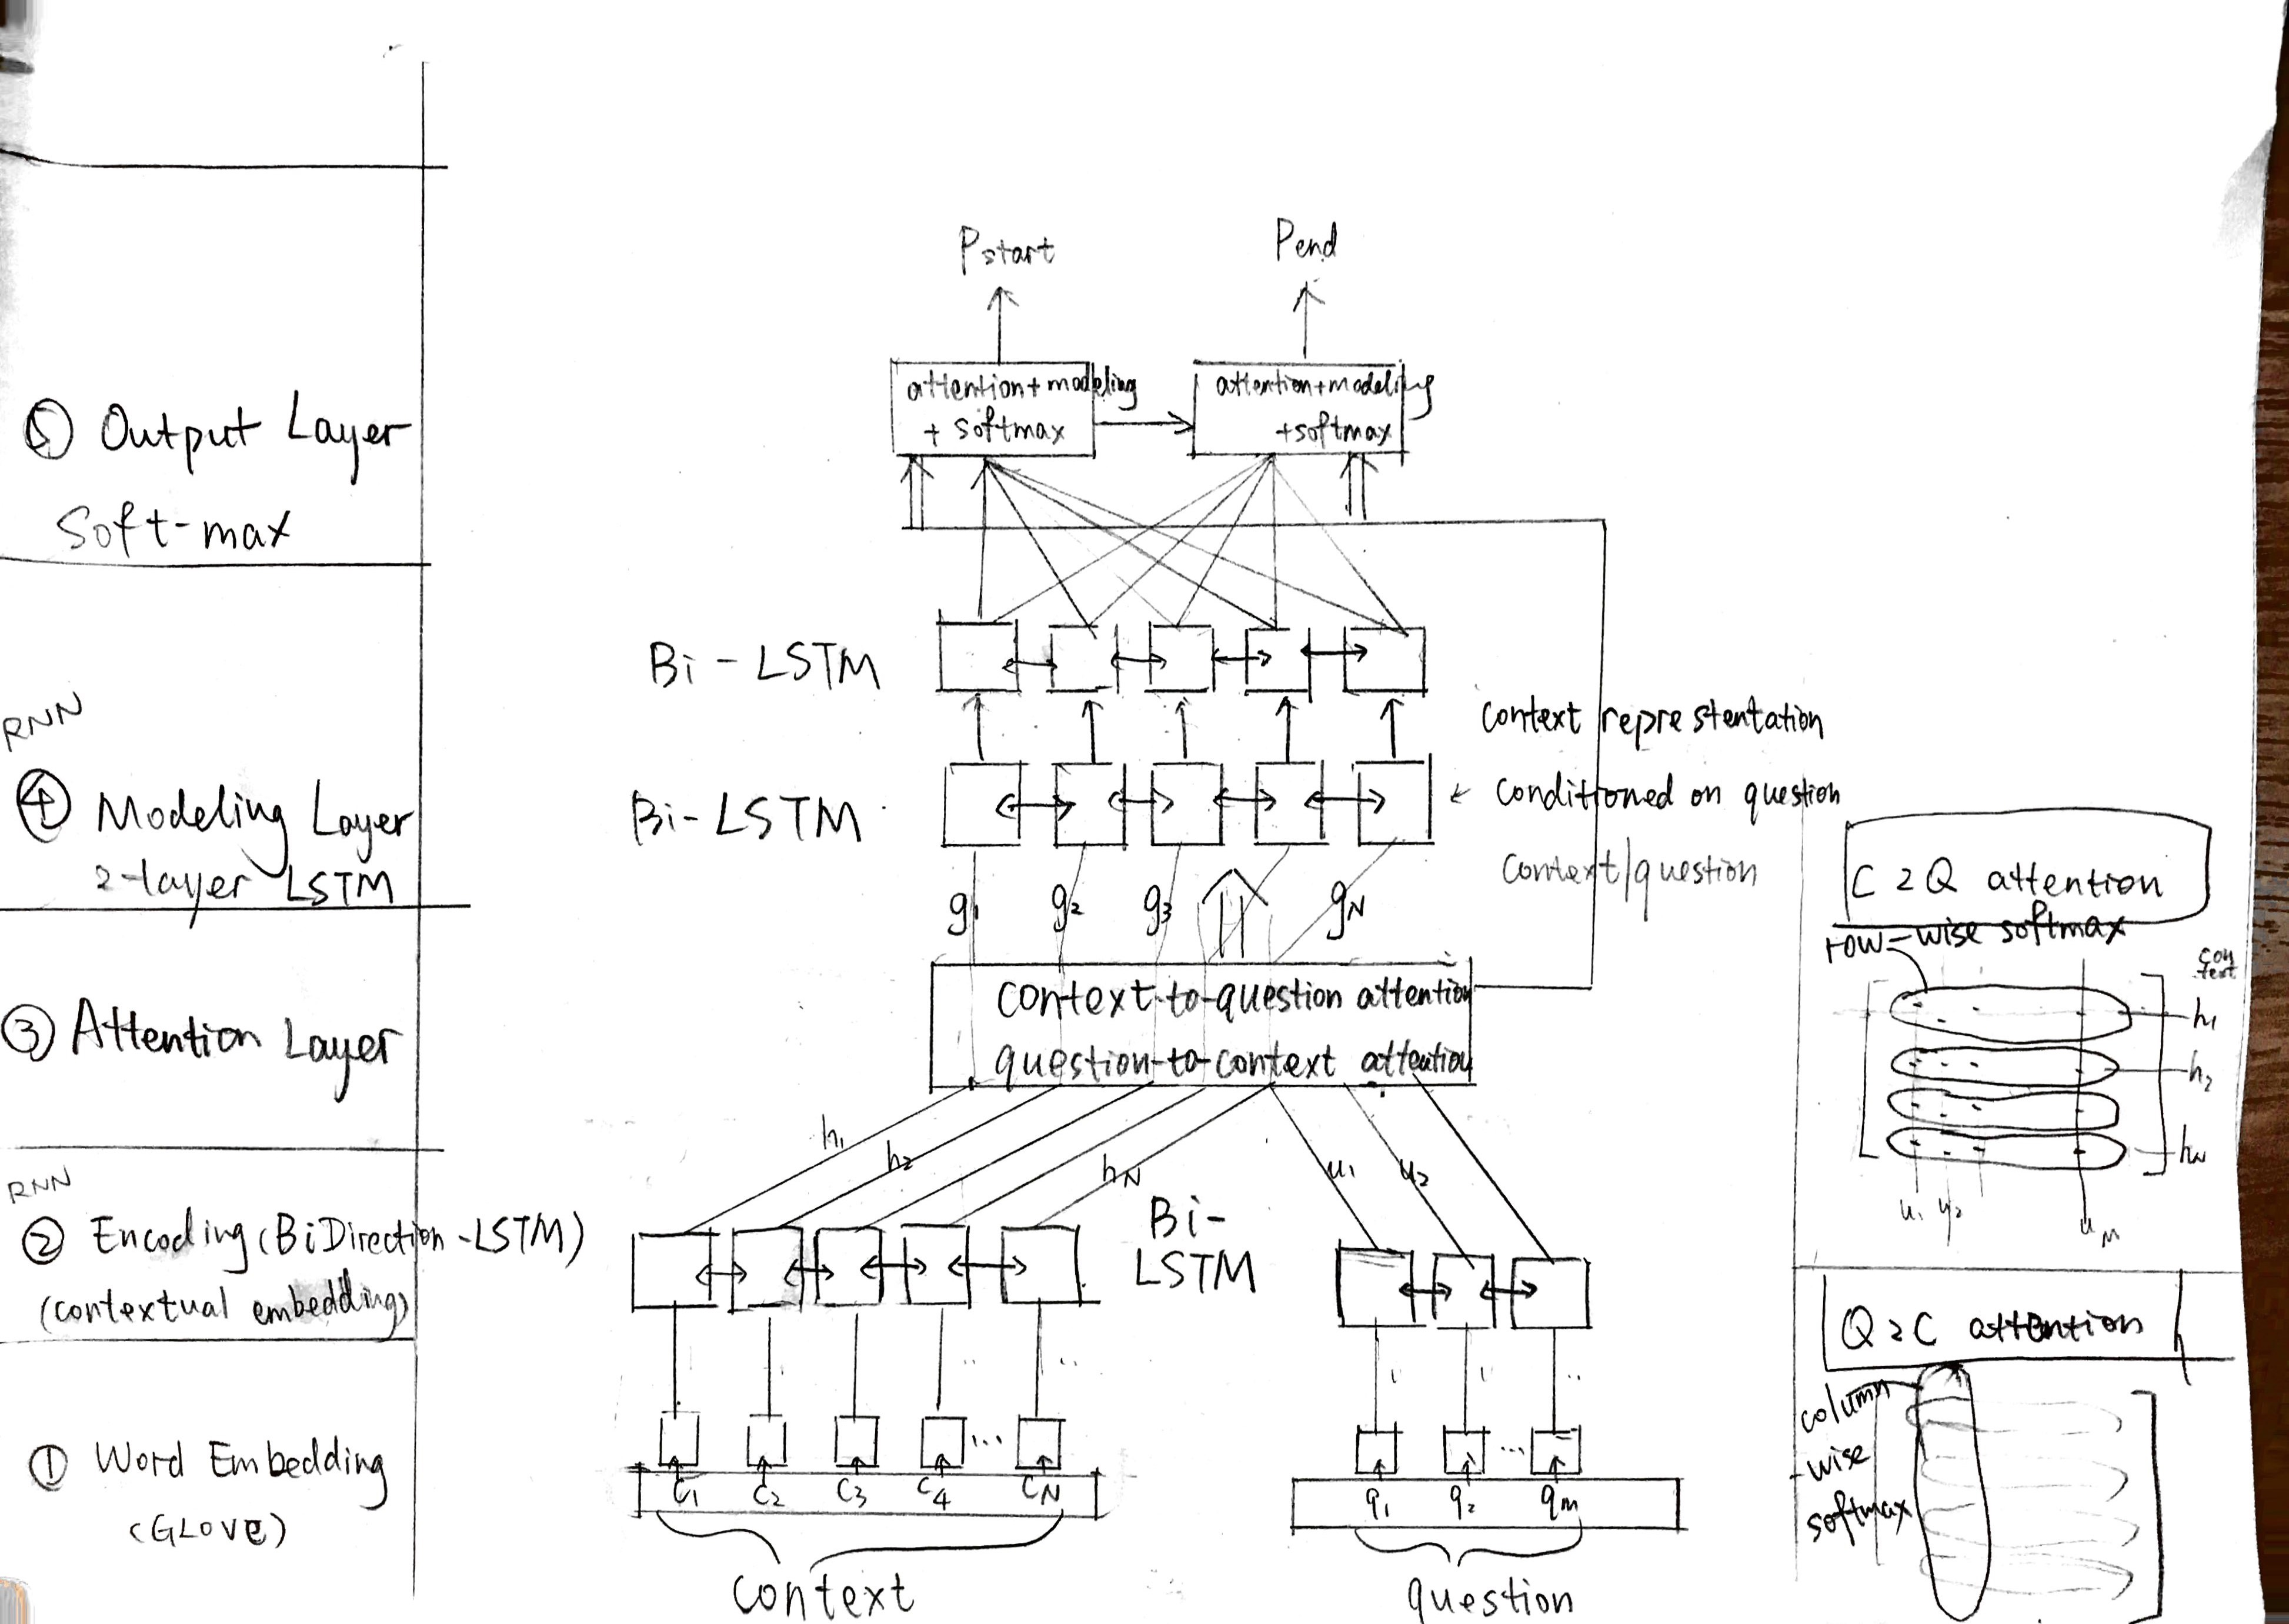

In [119]:
Image("dig1.JPG", width=600)

### 2.1.2 Performance of Baseline

##### set up of baseline

In [0]:
import torch.utils.data as data
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched

from collections import OrderedDict
from json import dumps


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!pip list
!pip install ujson
!pip install pytorch-lightning
!pip install tensorboardX
#! python setup.py

In [0]:
import os
os.chdir("drive/My Drive/squad")
#import sys  
#sys.path.insert(0, '/drive/My Drive/squad')



In [4]:
cd drive/My Drive/squad

/content/drive/My Drive/squad


In [0]:
!ls

 args.py		   QANet
 baseline_pred_dict.json  'qanet_train (1).py'
 config.py		   qanet_train.py
 data			   README.md
 environment.yml	   save
 layers.py		  'Screen Shot 2019-11-27 at 5.00.51 PM.png'
 LICENSE		   setup.py
 log			   test.py
 model			   train.py
 models.py		   transformer_qanet.py
 modelsqa.py		   util.py
 __pycache__


In [0]:
import util
import models
from models import BiDAF
from tensorboardX import SummaryWriter
from tqdm import tqdm
from ujson import load as json_load
from util import collate_fn, SQuAD

#### run baseline 

In [0]:
! python train.py --hidden_size=128 --batch_size=64 --num_epochs=15 --load_path='./save/train/baseline-10/step_1551510.pth.tar' -n baseline

[11.26.19 22:54:07] Args: {
    "batch_size": 64,
    "char_emb_file": "./data/char_emb.json",
    "dev_eval_file": "./data/dev_eval.json",
    "dev_record_file": "./data/dev.npz",
    "drop_prob": 0.2,
    "ema_decay": 0.999,
    "eval_steps": 50000,
    "gpu_ids": [
        0
    ],
    "hidden_size": 128,
    "l2_wd": 0,
    "load_path": "./save/train/baseline-04/step_1000974.pth.tar",
    "lr": 0.5,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "maximize_metric": true,
    "metric_name": "F1",
    "name": "baseline",
    "num_epochs": 15,
    "num_visuals": 10,
    "num_workers": 4,
    "save_dir": "./save/train/baseline-10",
    "seed": 224,
    "test_eval_file": "./data/test_eval.json",
    "test_record_file": "./data/test.npz",
    "train_eval_file": "./data/train_eval.json",
    "train_record_file": "./data/train.npz",
    "use_squad_v2": true,
    "word_emb_file": "./data/word_emb.json"
}
[11.26.19 22:54:07] Using random seed 224...
[11.26.19 2

In [0]:
#!python test.py --split 'dev' --load_path save/train/baseline-04 --name dev_run

In [0]:
! python train.py --hidden_size=128 --batch_size=64 --num_epochs=15 --load_path='./save/train/baseline-04/step_1000974.pth.tar' -n baseline

#### -------- baseline output end ----------
#### ---------baseline get result on development set-------
#### F1 Score on Dev Set = 61.03, 
#### EM on Dev Set = 57.75

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from squad.util import collate_fn, SQuAD
from collections import OrderedDict
from json import dumps
from ujson import load as json_load
import pytorch_lightning as pl

from squad import layers, util




In [0]:
seed = 224
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [0]:
DIR

'/content/drive/My Drive/squad'

In [0]:
DIR = os.getcwd()
## load dataset 
# train_path = os.path.join(DIR, 'data/train.npz')
# train_loader = data.DataLoader(SQuAD(train_path),
#                                batch_size=128,
#                                shuffle=True,
#                                drop_last=True,
#                                collate_fn=collate_fn)

dev_path = os.path.join(DIR, 'data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)
# test_path = os.path.join(DIR, 'data/test.npz')
# test_loader = data.DataLoader(SQuAD(test_path),
#                                batch_size=128,
#                                shuffle=True,
#                                drop_last=True,
#                                collate_fn=collate_fn)


In [0]:
#how to read dev_loader inside
for batch in dev_loader:
    break

cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids = batch 

In [0]:
cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids

In [0]:
args = {
    "batch_size": 64,
    "char_emb_file": "./data/char_emb.json",
    "dev_eval_file": "./data/dev_eval.json",
    "dev_record_file": "./data/dev.npz",
    "drop_prob": 0.2,
    "ema_decay": 0.999,
    "eval_steps": 50000,
    "gpu_ids": [
        0
    ],
    "hidden_size": 128,
    "l2_wd": 0,
    "load_path": "./save/train/baseline-04/step_1000974.pth.tar",
    "lr": 0.5,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "maximize_metric": True,
    "metric_name": "F1",
    "name": "baseline",
    "num_epochs": 15,
    "num_visuals": 10,
    "num_workers": 4,
    "save_dir": "./save/train/baseline-10",
    "seed": 224,
    "test_eval_file": "./data/test_eval.json",
    "test_record_file": "./data/test.npz",
    "train_eval_file": "./data/train_eval.json",
    "train_record_file": "./data/train.npz",
    "use_squad_v2": True,
    "word_emb_file": "./data/word_emb.json"
}


In [0]:
args

In [0]:
# model = BiDAF(word_vectors=word_vectors,
#                   hidden_size=args.hidden_size,
#                   drop_prob=args.drop_prob)
#     model = nn.DataParallel(model, args.gpu_ids)
#     if args.load_path:
#         log.info(f'Loading checkpoint from {args.load_path}...')
#         model, step = util.load_model(model, args.load_path, args.gpu_ids)

In [0]:
word_vectors = util.torch_from_json('./data/word_emb.json')
model = models.BiDAF(word_vectors=word_vectors,
                  hidden_size=128,
                  drop_prob=0.2)
model = nn.DataParallel(model, args['gpu_ids'])
best_path = 'save/train/baseline-10/best.pth.tar'
print(f'Loading checkpoint from {best_path}...')
model, step = util.load_model(model, best_path, args['gpu_ids'])

Loading checkpoint from save/train/baseline-10/best.pth.tar...


In [0]:
model

DataParallel(
  (module): BiDAF(
    (emb): Embedding(
      (embed): Embedding(88746, 300)
      (proj): Linear(in_features=300, out_features=128, bias=False)
      (hwy): HighwayEncoder(
        (transforms): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
        (gates): ModuleList(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=128, bias=True)
        )
      )
    )
    (enc): RNNEncoder(
      (rnn): LSTM(128, 128, batch_first=True, bidirectional=True)
    )
    (att): BiDAFAttention()
    (mod): RNNEncoder(
      (rnn): LSTM(1024, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    )
    (out): BiDAFOutput(
      (att_linear_1): Linear(in_features=1024, out_features=1, bias=True)
      (mod_linear_1): Linear(in_features=256, out_features=1, bias=True)
      (rnn): RNNEncoder(


In [0]:
def evaluate(model, data_loader, device, eval_file, max_len, use_squad_v2):
    nll_meter = util.AverageMeter()

    model.eval()
    pred_dict = {}
    with open(eval_file, 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad(), \
            tqdm(total=len(data_loader.dataset)) as progress_bar:
        for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
            # Setup for forward
            cw_idxs = cw_idxs.to(device)
            qw_idxs = qw_idxs.to(device)
            batch_size = cw_idxs.size(0)

            # Forward
            log_p1, log_p2 = model(cw_idxs, qw_idxs)
            y1, y2 = y1.to(device), y2.to(device)
            loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
            nll_meter.update(loss.item(), batch_size)

            # Get F1 and EM scores
            p1, p2 = log_p1.exp(), log_p2.exp()
            starts, ends = util.discretize(p1, p2, max_len, use_squad_v2)

            # Log info
            progress_bar.update(batch_size)
            progress_bar.set_postfix(NLL=nll_meter.avg)

            preds, _ = util.convert_tokens(gold_dict,
                                           ids.tolist(),
                                           starts.tolist(),
                                           ends.tolist(),
                                           use_squad_v2)
            pred_dict.update(preds)

    model.train()

    results = util.eval_dicts(gold_dict, pred_dict, use_squad_v2)
    results_list = [('NLL', nll_meter.avg),
                    ('F1', results['F1']),
                    ('EM', results['EM'])]
    if use_squad_v2:
        results_list.append(('AvNA', results['AvNA']))
    results = OrderedDict(results_list)

    return results, pred_dict

In [0]:
device, args['gpu_ids'] = util.get_available_devices()

In [0]:
ema = util.EMA(model, args['ema_decay'])
ema.assign(model)
results, pred_dict = evaluate(model, dev_loader, device, args['dev_eval_file'],
                                                  args['max_ans_len'],
                                                  args['use_squad_v2'])


In [0]:
saver = util.CheckpointSaver(args['save_dir'],
                                 max_checkpoints=args['max_checkpoints'],
                                 metric_name=args['metric_name'],
                                 maximize_metric=args['maximize_metric']
                                )
saver.save(step, model, results[args['metric_name']], device)
ema.resume(model)

In [0]:
results

In [0]:
torch.save({
  'epoch': epoch,
  'args': args,
  'state_dict': model.state_dict(),  # 1) OR
  'state_dict': model.module.state_dict(),  # 2)
  'loss_history': loss_history,
}, model_save_filename)

In [0]:
torch.save(model.state_dict(), './save/train/baseline-10/model_baseline.pth')

##### F1 Score on Dev Set: 61.03
##### EM on Dev Set: 57.75


#### hash model and json file for Q4

In [0]:
!md5sum ./save/train/baseline-10/model_baseline.pth

f3e34673cf270e6f1ffd28c946636b0b  ./save/train/baseline-10/model_baseline.pth


In [0]:
model.module.state_dict()

OrderedDict([('emb.embed.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
                      ...,
                      [ 0.3990, -0.0185,  0.3715,  ...,  0.0370, -0.0975, -0.6882],
                      [-0.0652, -0.0192, -0.8155,  ...,  0.9371, -0.4975, -1.1756],
                      [ 0.5272, -1.0988, -0.3210,  ..., -0.0951, -0.1996, -1.2129]],
                     device='cuda:0')),
             ('emb.proj.weight',
              tensor([[-0.0036,  0.1557,  0.2192,  ...,  0.0554, -0.0763,  0.2182],
                      [-0.2224,  0.3507, -0.0494,  ...,  0.1258, -0.0815, -0.3787],
                      [-0.1275, -0.1877, -0.3751,  ...,  0.1799,  0.1552,  0.1390],
                      ...,
                      [-0.0562, -0.0580, -0.2028,  ...,  0.2391,  0.1133,  0.4378]

In [0]:
import json
json_string = json.dumps(pred_dict)
json_string 

In [0]:
with open('baseline_pred_dict.json', 'w') as json_file:
    json.dump(pred_dict, json_file)


## 2.2 Improving the Baseline

### 2.2.1 Diagram of your architecture

In [0]:
uploaded = files.upload()

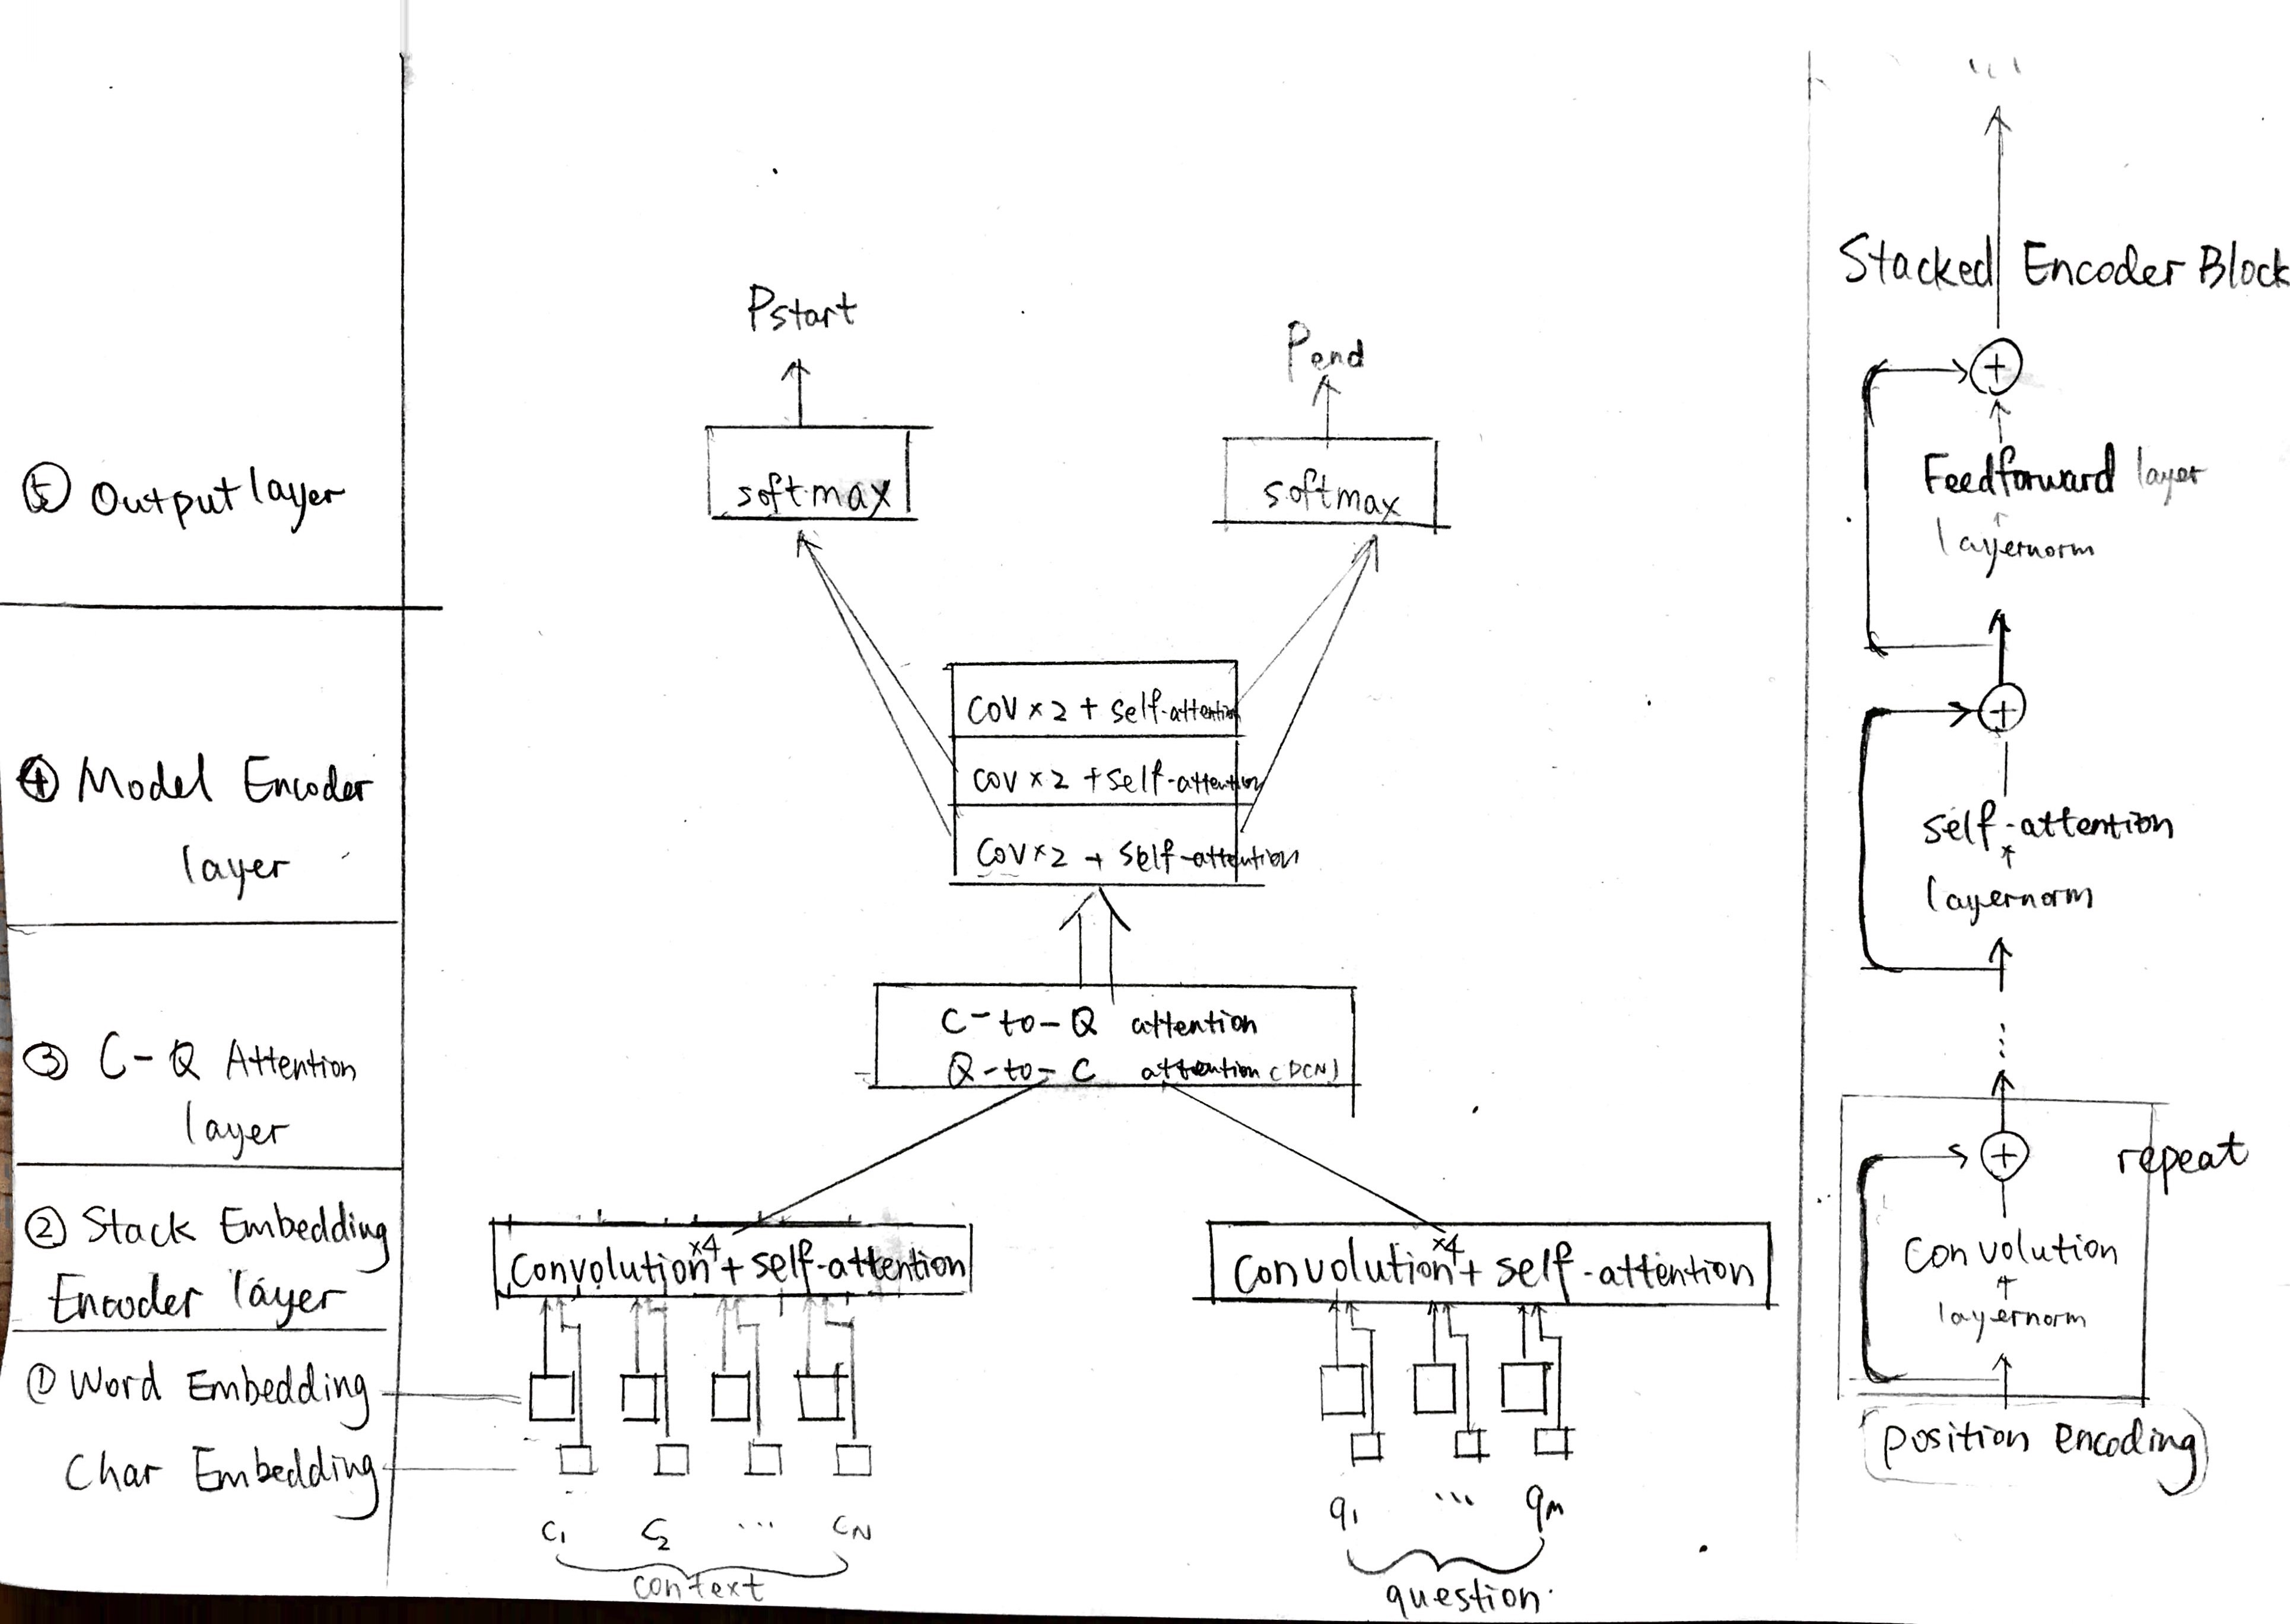

In [121]:
Image("dig2.JPG", width=600)

### 2.2.2 Performance of your Architecture

#### QANet Load


In [0]:
import util
import models
from models import BiDAF
from tensorboardX import SummaryWriter
from tqdm import tqdm
from ujson import load as json_load
from util import collate_fn, SQuAD

In [33]:
!git clone https://github.com/BangLiu/QANet-PyTorch.git

Cloning into 'QANet-PyTorch'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 106.68 KiB | 296.00 KiB/s, done.
Resolving deltas: 100% (79/79), done.


#### model_improved run

#### run model - start

In [47]:
!python qanet_train_v3.py --batch_size 64 --hidden_size 128 --num_epochs 30  -n QAimpor02

[12.04.19 12:08:01] Evaluating at step 900876...
 93% 121344/129922 [33:38<02:18, 62.08it/s, NLL=3.64, epoch=7]
  0% 0/5951 [00:00<?, ?it/s]
  1% 64/5951 [00:00<01:29, 65.76it/s]
  1% 64/5951 [00:00<01:29, 65.76it/s, NLL=2.34]
  2% 128/5951 [00:01<01:07, 86.17it/s, NLL=2.34]
  2% 128/5951 [00:01<01:07, 86.17it/s, NLL=2.34]
  3% 192/5951 [00:01<00:50, 114.39it/s, NLL=2.34]
  3% 192/5951 [00:01<00:50, 114.39it/s, NLL=2.24]
  4% 256/5951 [00:01<00:38, 149.47it/s, NLL=2.24]
  4% 256/5951 [00:01<00:38, 149.47it/s, NLL=2.41]
  5% 320/5951 [00:01<00:29, 189.27it/s, NLL=2.41]
  5% 320/5951 [00:01<00:29, 189.27it/s, NLL=2.55]
  6% 384/5951 [00:01<00:23, 233.55it/s, NLL=2.55]
  6% 384/5951 [00:01<00:23, 233.55it/s, NLL=2.66]
  8% 448/5951 [00:01<00:19, 279.81it/s, NLL=2.66]
  8% 448/5951 [00:01<00:19, 279.81it/s, NLL=2.66]
  9% 512/5951 [00:01<00:16, 326.07it/s, NLL=2.66]
  9% 512/5951 [00:01<00:16, 326.07it/s, NLL=2.66]
 10% 576/5951 [00:02<00:16, 335.02it/s, NLL=2.66]
 10% 576/5951 [00:02<00:1

#### ignore epoch = 5 (previous trained)

In [0]:
!python qanet_train.py --num_epochs 5 --load_path 'best.pth.tar' -n QAimpor

In [0]:
!python qanet_train.py --num_epochs 5 --load_path 'best.pth.tar' -n QAimpor

100% 129922/129922 [37:31<00:00, 57.71it/s, NLL=1.87, epoch=4]
[12.04.19 04:51:50] Starting epoch 5...
[12.04.19 05:00:38] Evaluating at step 550536...
 24% 30848/129922 [08:47<28:46, 57.39it/s, NLL=2.71, epoch=5]
  0% 0/5951 [00:00<?, ?it/s]
  1% 64/5951 [00:01<01:49, 53.71it/s]
  1% 64/5951 [00:01<01:49, 53.71it/s, NLL=2.52]
  2% 128/5951 [00:01<01:21, 71.43it/s, NLL=2.52]
  2% 128/5951 [00:01<01:21, 71.43it/s, NLL=2.59]
  3% 192/5951 [00:01<01:00, 95.67it/s, NLL=2.59]
  3% 192/5951 [00:01<01:00, 95.67it/s, NLL=2.51]
  4% 256/5951 [00:01<00:44, 127.02it/s, NLL=2.51]
  4% 256/5951 [00:01<00:44, 127.02it/s, NLL=2.75]
  5% 320/5951 [00:01<00:34, 161.98it/s, NLL=2.75]
  5% 320/5951 [00:01<00:34, 161.98it/s, NLL=2.91]
  6% 384/5951 [00:01<00:27, 203.51it/s, NLL=2.91]
  6% 384/5951 [00:01<00:27, 203.51it/s, NLL=2.96]
  8% 448/5951 [00:02<00:22, 247.18it/s, NLL=2.96]
  8% 448/5951 [00:02<00:22, 247.18it/s, NLL=2.94]
  9% 512/5951 [00:02<00:18, 291.60it/s, NLL=2.94]
  9% 512/5951 [00:02<00:1

#### --- end of improved_model output ------
####  result output

In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from squad.util import collate_fn, SQuAD
from collections import OrderedDict
from json import dumps
from ujson import load as json_load
import pytorch_lightning as pl

from squad import layers, util


DIR = os.getcwd()


In [0]:

dev_path = os.path.join(DIR, 'data/dev.npz')
dev_loader = data.DataLoader(SQuAD(dev_path),
                               batch_size=64,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=collate_fn)

In [0]:
#how to read dev_loader inside
for batch in dev_loader:
    break

cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids = batch 

In [16]:
cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids

(tensor([[    1,    91,  1317,  ...,     0,     0,     0],
         [    1,     1,     2,  ...,     0,     0,     0],
         [    1,    91,   423,  ...,     0,     0,     0],
         ...,
         [    1,    24,  1038,  ...,     0,     0,     0],
         [    1,  1891,     4,  ...,     0,     0,     0],
         [    1,  5109, 10636,  ...,     0,     0,     0]]),
 tensor([[[ 1,  1,  1,  ...,  1,  1,  1],
          [64,  6,  0,  ...,  0,  0,  0],
          [75, 43, 18,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],
 
         [[ 1,  1,  1,  ...,  1,  1,  1],
          [29, 18, 10,  ...,  0,  0,  0],
          [36,  0,  0,  ...,  0,  0,  0],
          ...,
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0],
          [ 0,  0,  0,  ...,  0,  0,  0]],
 
         [[ 1,  1,  1,  ...,  1,  1,  1],
          [64,  6,  0,  ...,  0,  0,  0],
      

In [0]:
args =  {
    "batch_size": 64,
    "char_emb_file": "./data/char_emb.json",
    "dev_eval_file": "./data/dev_eval.json",
    "dev_record_file": "./data/dev.npz",
    "drop_prob": 0.2,
    "ema_decay": 0.999,
    "eval_steps": 50000,
    "gpu_ids": [
        0
    ],
    "hidden_size": 128,
    "l2_wd": 0,
    "load_path": './save/train/QAimpor02-01/step_1801754.pth.tar',
    "lr": 0.5,
    "max_ans_len": 15,
    "max_checkpoints": 5,
    "max_grad_norm": 5.0,
    "maximize_metric": True,
    "metric_name": "F1",
    "name": "QAimpor02",
    "num_epochs": 30,
    "num_visuals": 10,
    "num_workers": 4,
    "save_dir": "./save/train/QAimpor02-01",
    "seed": 224,
    "test_eval_file": "./data/test_eval.json",
    "test_record_file": "./data/test.npz",
    "train_eval_file": "./data/train_eval.json",
    "train_record_file": "./data/train.npz",
    "use_squad_v2": True,
    "word_emb_file": "./data/word_emb.json"
}

# [12.04.19 16:19:40] Saved checkpoint: ./save/train/QAimpor02-01/step_1801754.pth.tar
# [12.04.19 16:19:41] New best checkpoint at step 1801754...
# [12.04.19 16:19:41] Removed checkpoint: ./save/train/QAimpor02-01/step_1601560.pth.tar
# [12.04.19 16:19:41] Dev NLL: 02.84, F1: 64.27, EM: 61.00, AvNA: 70.66
#  87% 112960/129922 [31:53<16:23, 17.24it/s, NLL=2.57, epoch=14]

In [0]:
args

#### load package

In [0]:
# -*- coding: utf-8 -*-
import os
import sys
import pickle


def replace_sep(fin, fout, sep_ini, sep_fin):
    """
    Replace delimiter in a file.
    """
    fin = open(fin, "r")
    fout = open(fout, "w")
    for line in fin:
        fout.write(line.replace(sep_ini, sep_fin))
    fin.close()
    fout.close()


def remove_quotes(fin, fout):
    """
    Remove quotes in lines.
    If a line has odd number quotes, remove all quotes in this line.
    """
    fin = open(fin)
    fout = open(fout, "w")
    for line in fin:
        fout.write(line.replace("\"", ""))
    fin.close()
    fout.close()


def pickle_dump_large_file(obj, filepath):
    """
    This is a defensive way to write pickle.write,
    allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    bytes_out = pickle.dumps(obj)
    n_bytes = sys.getsizeof(bytes_out)
    with open(filepath, 'wb') as f_out:
        for idx in range(0, n_bytes, max_bytes):
            f_out.write(bytes_out[idx:idx + max_bytes])


def pickle_load_large_file(filepath):
    """
    This is a defensive way to write pickle.load,
    allowing for very large files on all platforms
    """
    max_bytes = 2**31 - 1
    input_size = os.path.getsize(filepath)
    bytes_in = bytearray(0)
    with open(filepath, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    obj = pickle.loads(bytes_in)
    return obj


def make_path(filepath):
    d = os.path.dirname(filepath)
    if d and not os.path.exists(d):
        os.makedirs(d)
    return filepath


#### ignore

In [0]:
#from QANet.util import file_utils as file_utils

In [0]:
from QANet.data_loader import SQuAD
from QANet import QANet_main

In [0]:
from QANet.model.QANet import QANet


In [81]:
!ls

 args.py		   QANet_1
 baseline_pred_dict.json   qanet_train_v1.py
 config.py		   qanet_train_v2.py
 data			   qanet_train_v3.py
 environment.yml	   README.md
 layers.py		   save
 LICENSE		  'Screen Shot 2019-11-27 at 5.00.51 PM.png'
 log			   setup.py
 model			   test.py
 models.py		   train.py
 modelsqa.py		   transformer_qanet.py
 __pycache__		   util.py
 QANet


In [82]:
word_vectors = util.torch_from_json('./data/word_emb.json')
char_vectors = util.torch_from_json('./data/char_emb.json')

model = QANet(word_mat = word_vectors, char_mat = char_vectors,
                  c_max_len = 400, q_max_len = 50,
                  d_model = 128)

model = nn.DataParallel(model, args['gpu_ids'])
best_path = './save/train/QAimpor02-01/best.pth.tar'


print(f'Loading checkpoint from {best_path}...')
model, step = util.load_model(model, best_path, args['gpu_ids'])

Loading checkpoint from ./save/train/QAimpor02-01/best.pth.tar...


In [83]:
model

DataParallel(
  (module): QANet(
    (char_emb): Embedding(1376, 64)
    (word_emb): Embedding(88746, 300)
    (emb): Embedding(
      (conv2d): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1))
      (conv1d): Initialized_Conv1d(
        (out): Conv1d(428, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
      (high): Highway(
        (linear): ModuleList(
          (0): Initialized_Conv1d(
            (out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
          )
          (1): Initialized_Conv1d(
            (out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
          )
        )
        (gate): ModuleList(
          (0): Initialized_Conv1d(
            (out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
          )
          (1): Initialized_Conv1d(
            (out): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
          )
        )
      )
    )
    (emb_enc): EncoderBlock(
      (convs): ModuleList(
        (0): DepthwiseSeparableConv(
          (depthwise_

In [0]:
# model = QANet(
#         wv_tensor,
#         cv_tensor,
#         args.para_limit,
#         args.ques_limit,
#         args.d_model,
#         num_head=args.num_head,
#         train_cemb=(not args.pretrained_char),
#         pad=wv_word2ix["<PAD>"])
#     model.summary()

#### evaluate on dev set
-------
#### F1 Score on Dev Set = 64.27112864320294, 
#### EM on Dev Set = 60.97146739130435

In [0]:
### code to load your model and evaluate on the dev set

### model = load on previous cell

# def evaluate_on_dev_set(model, devloader):
#     return f1_score, em_score

In [0]:
def evaluate(model, data_loader, device, eval_file, max_len, use_squad_v2):
    nll_meter = util.AverageMeter()

    model.eval()
    pred_dict = {}
    with open(eval_file, 'r') as fh:
        gold_dict = json_load(fh)
    with torch.no_grad(), \
            tqdm(total=len(data_loader.dataset)) as progress_bar:
        for cw_idxs, cc_idxs, qw_idxs, qc_idxs, y1, y2, ids in data_loader:
            # Setup for forward
            cw_idxs = cw_idxs.to(device)
            qw_idxs = qw_idxs.to(device)
            cc_idxs = cc_idxs.to(device)
            qc_idxs = qc_idxs.to(device)
            batch_size = cw_idxs.size(0)

            # Forward
            p1, p2 = model(cw_idxs, cc_idxs, qw_idxs, qc_idxs)
            log_p1, log_p2 = F.log_softmax(p1), F.log_softmax(p2)
            y1, y2 = y1.to(device), y2.to(device)
            loss = F.nll_loss(log_p1, y1) + F.nll_loss(log_p2, y2)
            nll_meter.update(loss.item(), batch_size)

            # Get F1 and EM scores
            p1, p2 = log_p1.exp(), log_p2.exp()
            starts, ends = util.discretize(p1, p2, max_len, use_squad_v2)

            # Log info
            progress_bar.update(batch_size)
            progress_bar.set_postfix(NLL=nll_meter.avg)

            preds, _ = util.convert_tokens(gold_dict,
                                           ids.tolist(),
                                           starts.tolist(),
                                           ends.tolist(),
                                           use_squad_v2)
            pred_dict.update(preds)

    model.train()

    results = util.eval_dicts(gold_dict, pred_dict, use_squad_v2)
    results_list = [('NLL', nll_meter.avg),
                    ('F1', results['F1']),
                    ('EM', results['EM'])]
    if use_squad_v2:
        results_list.append(('AvNA', results['AvNA']))
    results = OrderedDict(results_list)

    return results, pred_dict

In [0]:
device, args['gpu_ids'] = util.get_available_devices()

In [86]:
ema = util.EMA(model, args['ema_decay'])
ema.assign(model)
results, pred_dict = evaluate(model, dev_loader, device, args['dev_eval_file'],
                                                  args['max_ans_len'],
                                                  args['use_squad_v2'])


 99%|█████████▉| 5888/5951 [00:34<00:00, 169.32it/s, NLL=2.85]


In [0]:
# saver = util.CheckpointSaver(args['save_dir'],
#                                  max_checkpoints=args['max_checkpoints'],
#                                  metric_name=args['metric_name'],
#                                  maximize_metric=args['maximize_metric']
#                                 )
# saver.save(step, model, results[args['metric_name']], device)
# ema.resume(model)

In [87]:
results

OrderedDict([('NLL', 2.8490192786506983),
             ('F1', 64.27112864320294),
             ('EM', 60.97146739130435),
             ('AvNA', 70.68614130434783)])

In [88]:
pred_dict

{'1193': 'four',
 '5796': 'vector quantities',
 '391': '',
 '3094': '1290',
 '735': 'Alsace',
 '4243': 'Islamic Republic',
 '4936': 'Victory Square',
 '5959': 'Maxwell',
 '1426': 'Corliss steam engine',
 '4584': '',
 '4390': '',
 '4471': '',
 '5482': '',
 '5499': '',
 '1314': '',
 '5062': 'to clean them of plants and sediments',
 '2052': 'cartels',
 '3082': '',
 '6034': '',
 '2983': 'Academy of the Pavilion of the Star of Literature',
 '1654': '',
 '5339': '',
 '1814': '1992',
 '5554': 'Ticonderoga Point',
 '820': 'Those Huguenots who stayed in France became Catholics',
 '3169': '12th century',
 '4632': '',
 '1508': 'first oil shock',
 '131': '',
 '4362': 'vicious and destructive',
 '5563': 'William Shirley',
 '5036': 'Park Ujazdowski',
 '5215': 'Wianki',
 '4703': 'Scandinavia and northern Europe',
 '974': 'Catholics',
 '224': '',
 '1709': '',
 '1974': 'fundamental rights',
 '3299': 'specific immune receptors',
 '1007': 'E.I.',
 '785': 'Dublin',
 '5265': '',
 '3433': '',
 '3358': 'exte

In [0]:
modelQA = model

#### hash model and to json file

In [0]:
saver = util.CheckpointSaver(args['save_dir'],
                                 max_checkpoints=args['max_checkpoints'],
                                 metric_name=args['metric_name'],
                                 maximize_metric=args['maximize_metric']
                                )
saver.save(step, model, results[args['metric_name']], device)
ema.resume(model)

In [0]:
torch.save(model.state_dict(), './save/train/QAimpor02-01/QA.pth')  # baseline-10 is covered! find the baseline by hash

In [105]:
!md5sum ./save/train/QAimpor02-01/QA.pth

1d7c3a76193baaebb522d4cb12a6f61c  ./save/train/QAimpor02-01/QA.pth


In [91]:
model.module.state_dict()

OrderedDict([('char_emb.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.0593, -0.0499, -0.0076,  ...,  0.1451,  0.0268, -0.0237],
                      ...,
                      [ 0.0354,  0.1090, -0.0611,  ..., -0.0917,  0.1827,  0.0424],
                      [ 0.0212,  0.0480, -0.1241,  ...,  0.0188,  0.1500, -0.1444],
                      [ 0.0325,  0.1666,  0.0091,  ..., -0.0300,  0.2413, -0.1146]],
                     device='cuda:0')),
             ('word_emb.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [-0.0828,  0.6720, -0.1499,  ..., -0.1918, -0.3785, -0.0659],
                      ...,
                      [ 0.3990, -0.0185,  0.3715,  ...,  0.0370, -0.0975, -0.6882],

In [89]:
import json
json_string = json.dumps(pred_dict)
json_string 

'{"1193": "four", "5796": "vector quantities", "391": "", "3094": "1290", "735": "Alsace", "4243": "Islamic Republic", "4936": "Victory Square", "5959": "Maxwell", "1426": "Corliss steam engine", "4584": "", "4390": "", "4471": "", "5482": "", "5499": "", "1314": "", "5062": "to clean them of plants and sediments", "2052": "cartels", "3082": "", "6034": "", "2983": "Academy of the Pavilion of the Star of Literature", "1654": "", "5339": "", "1814": "1992", "5554": "Ticonderoga Point", "820": "Those Huguenots who stayed in France became Catholics", "3169": "12th century", "4632": "", "1508": "first oil shock", "131": "", "4362": "vicious and destructive", "5563": "William Shirley", "5036": "Park Ujazdowski", "5215": "Wianki", "4703": "Scandinavia and northern Europe", "974": "Catholics", "224": "", "1709": "", "1974": "fundamental rights", "3299": "specific immune receptors", "1007": "E.I.", "785": "Dublin", "5265": "", "3433": "", "3358": "extended in phagocytes to include engulfment o

In [0]:
with open('QA_pred_dict.json', 'w') as json_file:
    json.dump(pred_dict, json_file)

## 3 Fine Tuning Bert

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-jts_efc2
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-jts_efc2
     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 47.3MB/s 
     |████████████████████████████████| 860kB 40.1MB/s 
  Created wheel for transformers: filename=transformers-2.2.1-cp36-none-any.whl size=363121 sha256=5e85b3d2eefc86c252f337d6b3b9634598b33ded315b7334c797db836fa734fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ffkfuvjz/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=32e84a2bf7935a4ca961fa8548934be9b2766f584fb3396fcebbfb78412088ea
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built transformers sacremoses


In [0]:
! python ./examples/run_squad.py \
  --model_type bert \
  --model_name_or_path bert-base-cased \
  --do_train \
  --do_eval \
  --do_lower_case \
  --train_file train-v2.0.json \
  --predict_file dev-v2.0.json \
  --version_2_with_negative\
  --per_gpu_train_batch_size 12 \
  --learning_rate 3e-5 \
  --num_train_epochs 2.0 \
  --max_seq_length 384 \
  --doc_stride 128 \
  --output_dir /content/drive/'My Drive'/transformer/results/ \

In [0]:
import os
os.chdir('/content/drive/My Drive/transformer')
#! mkdir /content/drive/'My Drive'/transformer/test

In [0]:
os.chdir('/content/drive/My Drive/bi-att-flow/squad')

In [0]:
!python /content/drive/'My Drive'/transformer/test/evaluate-v2.0.py '/content/drive/My Drive/transformer/dev-v2.0.json' '/content/drive/My Drive/transformer/results/predictions_.json'

{
  "exact": 73.57683448502797,
  "f1": 76.74072084364587,
  "total": 6078,
  "HasAns_exact": 72.40549828178695,
  "HasAns_f1": 79.01378051123022,
  "HasAns_total": 2910,
  "NoAns_exact": 74.65277777777777,
  "NoAns_f1": 74.65277777777777,
  "NoAns_total": 3168
}


##### F1 Score on Dev Set: 76.74

## 4 Analysis

Example 1:\
question:
when did Nors encampments ivolve into destructive incursions?\
gold answers:
''\
Bert answer: 10th century\
Baseline answer: First half of 10th century\
QANet answer: the first half of the 10th century

<!-- Example 2:\
question:
What river originally bounded the Duchy?\
gold answers:
['Seine', 'Epte', 'Seine']\
Bert answer: river Seine\
Baseline answer: ' '\
QANet answer: Seine -->

Example 2:\
question:
Who did Rollo sign the treaty of Saint-Clair-sur-Epte with?\
gold answers:
['King Charles III', 'King Charles III', 'King Charles III']\
Bert answer: King Charles III of West Francia and the famed Viking ruler Rollo\
Baseline answer: King Charles III of West Francia and the famed Viking ruler Rollo\
QANet answer: King Charles III of West Francia

Example 3:\
question:
Who was the first Byzantine mercenary to serve with the Normans?\
gold answers:
' '\
Bert answer: Hervé\
Baseline answer: Hervé\
QANet answer: Hervé\

Example 4:\
question:
Who did the Normans fight in Italy?\
gold answers:
' '\
Bert answer: the Pechenegs, the Bulgars, and especially the Seljuk Turks\
Baseline answer: the Pechenegs, the Bulgars\
QANet answer: the Pechenegs, the Bulgars\




In [0]:
import json

In [0]:
with open('/content/drive/My Drive/transformer/results/predictions_.json') as json_file:
    bert_prediction = json.load(json_file)

with open('/content/drive/My Drive/transformer/dev-v2.0.json') as json_file:
    dev_file = json.load(json_file)

In [0]:
with open('/content/drive/My Drive/transformer/dev-v2.0.json') as json_file:
    dev_file = json.load(json_file)

In [0]:
import string
import re
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  return white_space_fix(remove_articles(remove_punc(lower(s))))

In [0]:
def find_incorrect_prediction(data,prediction_file):
  i = 0
  for article in data['data']:
    for p in article['paragraphs']:
      for qa in p['qas']:
        if i<20:
          qid = qa['id']
          gold_answers = [a['text'] for a in qa['answers']
                            if normalize_answer(a['text'])]
          if not gold_answers:
          # For unanswerable questions, only correct answer is empty string
            gold_answers = ['']
          if prediction_file[qid] not in gold_answers:
            i+=1
            print(qid)
            print('question:')
            print(qa['question'])
            
            print('gold answers:')
            print(gold_answers)
          
            print('my answer:')
            print(prediction_file[qid])
            print('-'*10)
        else:
          break

             

In [0]:
find_incorrect_prediction(dev_file,bert_prediction)

f9183ead5bb93aaa12ea37245
question:
From which countries did the Norse originate?
gold answers:
['Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway', 'Denmark, Iceland and Norway']
my answer:

----------
faf67818ee17102d8c16cc9e5
question:
Who ruled the duchy of Normandy
gold answers:
['Richard I', 'Richard I', 'Richard I']
my answer:
Richard I of Normandy
----------
e688568f9e7fd2700aea3d75d
question:
What religion were the Normans
gold answers:
['Catholic', 'Catholic orthodoxy', 'Catholic']
my answer:
The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy
----------
e7a1efbabdb13fbc36df8e179
question:
What type of major impact did the Norman dynasty have on modern Europe?
gold answers:
['']
my answer:
political, cultural and military
----------
71eb21da6ccfcfebdd3fc384e
question:
Who ruled the country of Normandy?
gold answers:
['']
my answer:
Richard I
----------
f

In [0]:
with open('/content/drive/My Drive/transformer/RNN_results/baseline_pred_dict.json') as json_file:
    baseline_prediction = json.load(json_file)

In [0]:
bert_prediction

{'68cf05f67fd29c6f129fe2fb9': 'France',
 'f5fead9187d56af2bdbfcb921': '10th and 11th centuries',
 'f9183ead5bb93aaa12ea37245': '',
 '1fc4da46445c2c1c2dc0ddeda': 'Rollo',
 '1be9fa378cbee6d9fa8b6ac78': '10th',
 'c42edddd0f45b968cc4c512e5': '',
 'd583847c96cbbbfaaa99dfcad': '',
 'e06fbbdb50af7ab3faefde618': '',
 'cbb48eaacbbbfcccefb7aab7f': '',
 '6d2fff36bcac0ea0e689a5a31': 'William the Conqueror',
 'faf67818ee17102d8c16cc9e5': 'Richard I of Normandy',
 'e688568f9e7fd2700aea3d75d': 'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy',
 'e7a1efbabdb13fbc36df8e179': 'political, cultural and military',
 'b5e6efbccbf6feb8dddbbce8d': '',
 'b3c16b20fa0daff05d74bedfc': '',
 '71eb21da6ccfcfebdd3fc384e': 'Richard I',
 'e1b5fab52e5afa35bf1cfce1c': '',
 'f8a7c2ed64befec7ec9c5ea0a': 'Norseman, Viking"',
 'eeacbc7e6ee75bc86b02ab940': '9th century',
 'c7d36363dff95f96e250cacac': '',
 '60cfd1e6211da7fbacbed6fc9': 'Mediev

In [0]:
baseline_prediction

{'5153': '2,000',
 '618': 'Manuel Blum',
 '6077': '',
 '382': '',
 '2434': 'Larry Roberts',
 '3415': 'T cell receptor',
 '4879': '1569',
 '2965': 'the comprehensive institutions of the Great Yuan',
 '390': '',
 '5264': 'a sword',
 '121': 'Sybilla of Normandy',
 '2851': '',
 '883': '',
 '965': '1530',
 '5123': 'emerging market',
 '5665': 'Governor Vaudreuil',
 '1773': 'European Court of Justice',
 '5312': '',
 '3361': '50%',
 '335': 'deterministic Turing machines, probabilistic Turing machines, non-deterministic Turing machines',
 '473': '',
 '4276': 'Algeria',
 '417': '',
 '3696': '',
 '4987': 'mannerist architecture',
 '1037': '',
 '4805': 'Istanbul',
 '5149': '',
 '3751': '',
 '4116': 'dangerous enemies',
 '2662': '',
 '2585': '',
 '5396': 'no French regular army troops',
 '4178': 'Sayyid Abul Ala Maududi',
 '3998': '',
 '1885': 'Court of Justice',
 '273': 'arbitrary',
 '3807': '',
 '1787': 'European Court of Justice',
 '2146': 'October 2007',
 '1982': '',
 '4855': '',
 '1370': '1606

In [0]:
baseline_prediction['f9183ead5bb93aaa12ea37245']

NameError: ignored

In [0]:
baseline_prediction['faf67818ee17102d8c16cc9e5']

'Richard I of Normandy'

In [0]:
baseline_prediction['e688568f9e7fd2700aea3d75d']

'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy'

In [0]:
prediction

{'68cf05f67fd29c6f129fe2fb9': 'France',
 'f5fead9187d56af2bdbfcb921': '10th and 11th centuries',
 'f9183ead5bb93aaa12ea37245': '',
 '1fc4da46445c2c1c2dc0ddeda': 'Rollo',
 '1be9fa378cbee6d9fa8b6ac78': '10th',
 'c42edddd0f45b968cc4c512e5': '',
 'd583847c96cbbbfaaa99dfcad': '',
 'e06fbbdb50af7ab3faefde618': '',
 'cbb48eaacbbbfcccefb7aab7f': '',
 '6d2fff36bcac0ea0e689a5a31': 'William the Conqueror',
 'faf67818ee17102d8c16cc9e5': 'Richard I of Normandy',
 'e688568f9e7fd2700aea3d75d': 'The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy',
 'e7a1efbabdb13fbc36df8e179': 'political, cultural and military',
 'b5e6efbccbf6feb8dddbbce8d': '',
 'b3c16b20fa0daff05d74bedfc': '',
 '71eb21da6ccfcfebdd3fc384e': 'Richard I',
 'e1b5fab52e5afa35bf1cfce1c': '',
 'f8a7c2ed64befec7ec9c5ea0a': 'Norseman, Viking"',
 'eeacbc7e6ee75bc86b02ab940': '9th century',
 'c7d36363dff95f96e250cacac': '',
 '60cfd1e6211da7fbacbed6fc9': 'Mediev

In [0]:
len(bert_prediction['data'])

KeyError: ignored

In [0]:
len(bert_prediction)

6078